In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import mean_squared_error

# models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# ignore warnings
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)

### DO NOTE

We are only plotting for Seasonals since data cleaning for seasons dropped all non-seasonals

In [150]:
# set categorical types
category_cols = ['Rating','Type','Status','Source','season','Studio']
int_cols = ['Rank','Episodes','Scored By','Popularity','Favorites','Members','Premier_Month']
float_cols = ['Score']

genres = ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi']
studios = ['Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'Wit Studio']

types = dict([(i,'category') for i in category_cols])

df = pd.read_csv('cleaned_data.csv')
df = df.astype(types)

### Split the df

In [151]:
# calculate number of datapoints for train set
def split_dataset(df:object, train_set_ratio:float):
    """splits a dataset, with the size of train_set being determined by train_set_ratio
    @param df: The dataframe to split
    @param train_set_ratio: Float between 0 and 1 to determine the ratio of the df to be the train_set
    @returns train_set: The train set
    @returns test_set: The test set"""

    # shuffle the data so we don't just take the first 20% as test set.
    df = df.sample(frac=1).reset_index(drop=True)

    # calculate the splits
    entry_count = len(df.index)
    train_count = (int)(entry_count*train_set_ratio)

    # split
    train_set = df[:train_count]
    test_set = df[train_count:]

    print(f'total: {entry_count}\ntrain: {train_set.shape}\ntest: {test_set.shape}')
    return train_set, test_set

train_set, test_set = split_dataset(df,0.8)

total: 4281
train: (3424, 101)
test: (857, 101)


### Plotting the numerical data

For Premier Month: Months since 1900 that the show premiered in

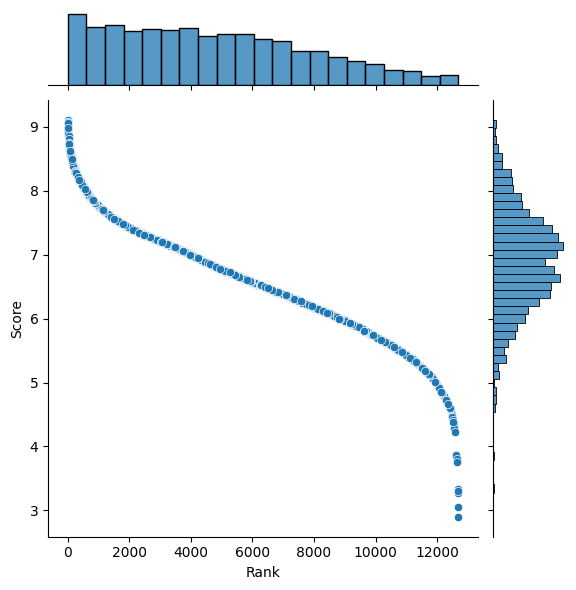

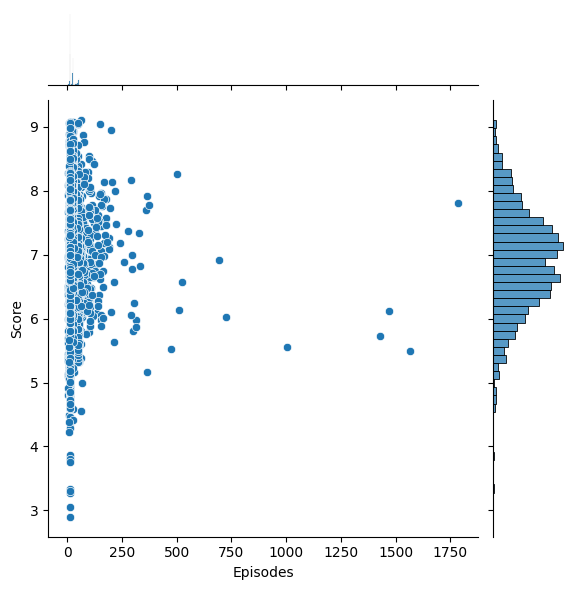

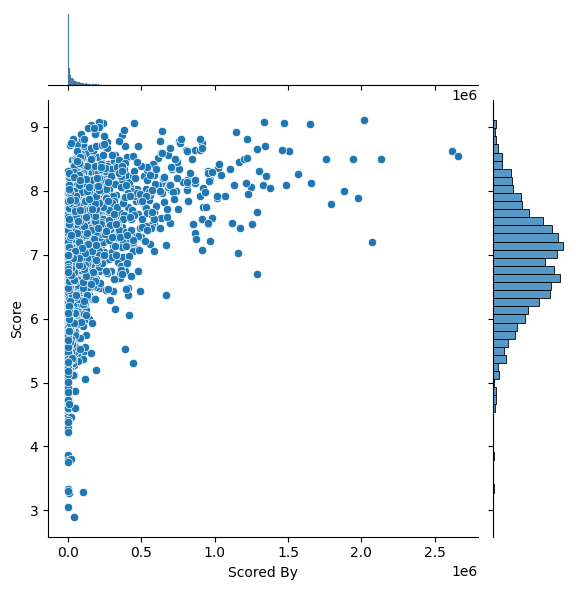

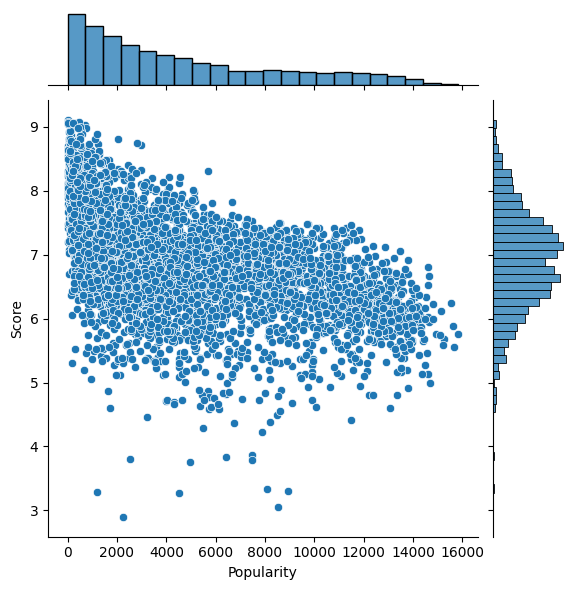

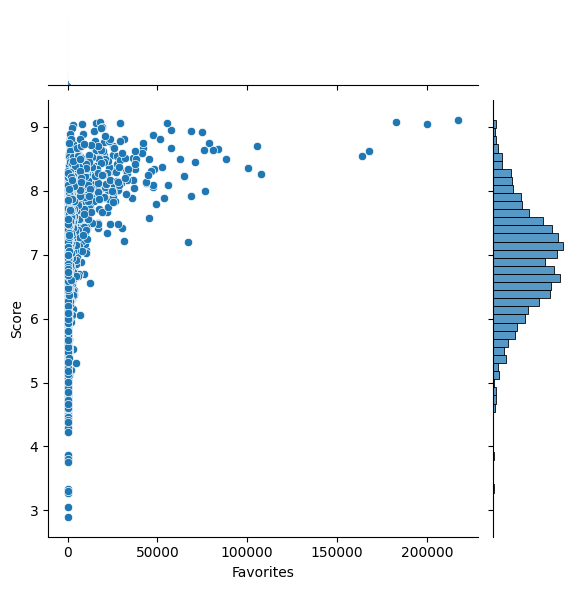

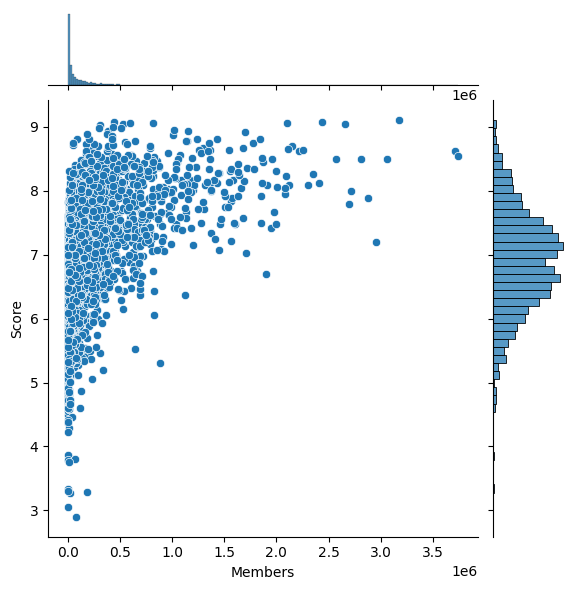

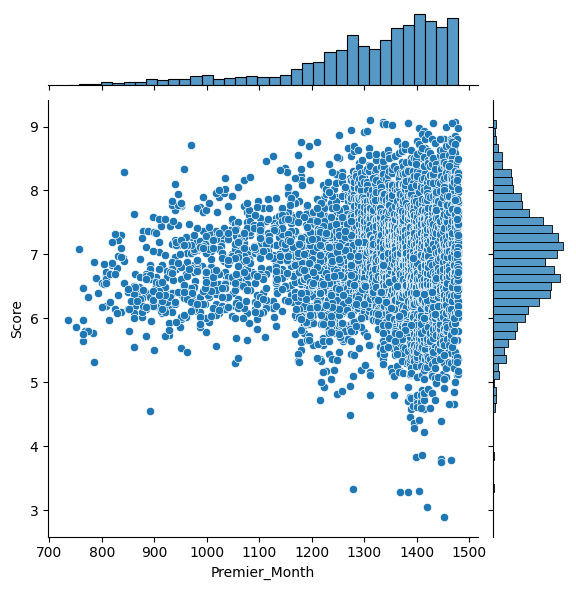

In [152]:
for y in int_cols:
    sb.jointplot(x=df[y],y=df['Score'])

### Linear Regression code yanked from Exercise 4

In [171]:
def prediction_plot(x:str, train_set:pd.DataFrame, test_set:pd.DataFrame, results:dict):
    """just a helper function to plot predictions against actuals"""
    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].scatter(train_set[[x]], results['train'], color = "blue")
    axes[0].plot(train_set[[x]], train_set[[x]], linewidth = 1, color = 'black')
    axes[0].set_xlabel(f"True values of {x}")
    axes[0].set_ylabel(f"Predicted values of {x}")
    axes[1].scatter(test_set[[x]], results['test'], color = "green")
    axes[1].plot(test_set[[x]], test_set[[x]], linewidth = 1, color='black')
    axes[1].set_xlabel(f"True values of {x}")
    axes[1].set_ylabel(f"Predicted values of {x}")
    plt.show()

def linear_regression(x:str, y:str, train_set:pd.DataFrame, test_set:pd.DataFrame):
    """does linear regression of variable y in the dataset against x. Can accept a list as y.
    @param x: The variable we want to predict
    @param y: The list of variables to perform regression on.
    @param train_set: The set used for training the model.
    @param test_set: The set used to test the model's accuracy.
    @returns R^2: The R^2 values of the model, train set then test set.
    @returns MSE: The MSE values of the model, train set then test set."""

    print(f'=============== {y} ===============')
    linreg = LinearRegression()
    # check if list
    if type(y) is list:
        linreg.fit(train_set[y],train_set[[x]])
    else:
        linreg.fit(train_set[[y]],train_set[[x]])

    # print the intercept & coef in the form y = m*x + c
    print(f"""Line Equation
        {x} = {linreg.coef_}*{y} + {linreg.intercept_}
        """)

    datasets = {'train':train_set, 'test':test_set}
    results = {}

    r2_arr = []
    mse_arr = []
    
    for name,dataset in datasets.items():
        if type(y) is list:
            datay = dataset[y]
        else:
            datay = dataset[[y]]
        pred = linreg.predict(datay)
        
        r2 = linreg.score(datay, dataset[[x]])
        mse = mean_squared_error(dataset[[x]], pred)

        r2_arr.append(r2)
        mse_arr.append(mse)

        print(f"""{name} dataset
        R^2: {r2}
        MSE: {mse}""")
        results[name] = pred

    prediction_plot(x,train_set,test_set,results)

    return r2_arr, mse_arr

### Performing Linear Regression

For Premier Month: Months passed since 1900 

=============== Rank ===============
Line Equation
        Score = [[-0.00024737]]*Rank + [8.05786303]
        
train dataset
        R^2: 0.9553890300259712
        MSE: 0.028681684406123998
test dataset
        R^2: 0.9557528431052484
        MSE: 0.028143440829329094


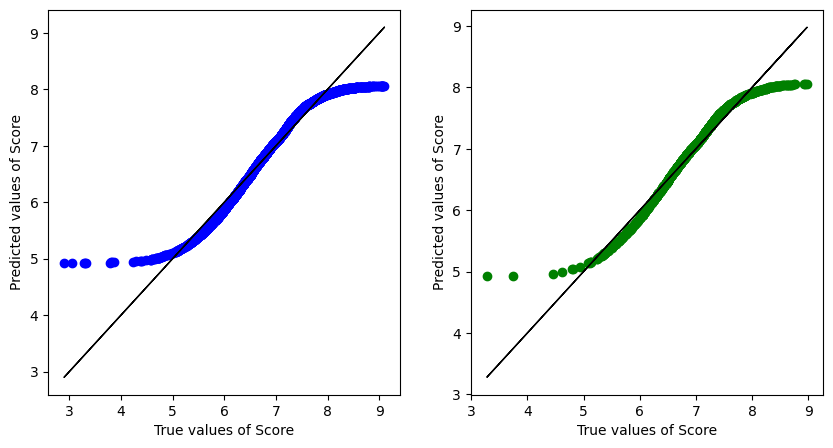

=============== Episodes ===============
Line Equation
        Score = [[-1.45247967e-05]]*Episodes + [6.87917405]
        
train dataset
        R^2: 1.112520188750743e-06
        MSE: 0.6429282419518935
test dataset
        R^2: -0.004978776731144885
        MSE: 0.6392175841928359


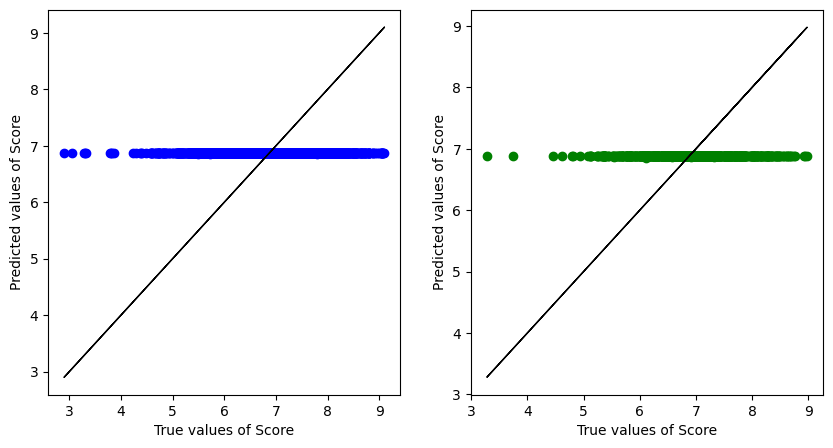

=============== Scored By ===============
Line Equation
        Score = [[1.66979282e-06]]*Scored By + [6.74376308]
        
train dataset
        R^2: 0.16482027938013433
        MSE: 0.5369612268722093
test dataset
        R^2: 0.19236791409828313
        MSE: 0.5136950578657105


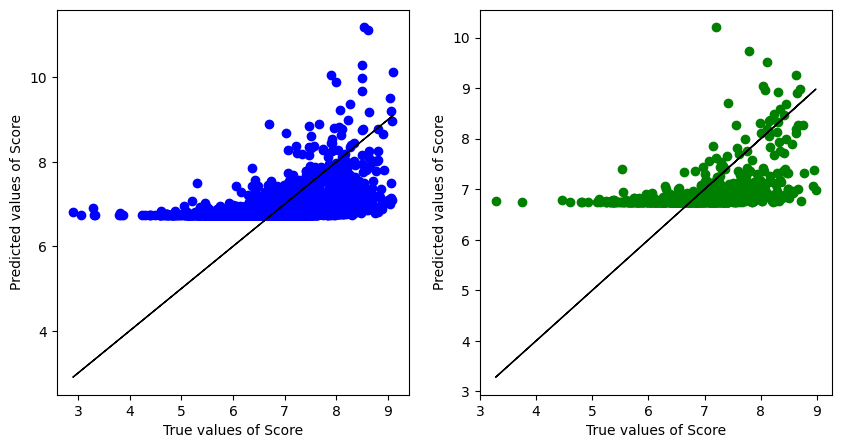

=============== Popularity ===============
Line Equation
        Score = [[-0.0001099]]*Popularity + [7.38843943]
        
train dataset
        R^2: 0.29236639927876407
        MSE: 0.45495813300790033
test dataset
        R^2: 0.2863511764159886
        MSE: 0.453916925944665


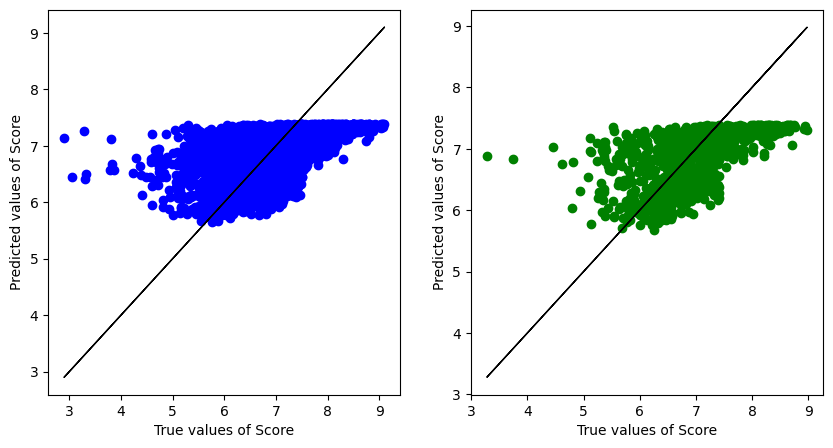

=============== Favorites ===============
Line Equation
        Score = [[2.73876307e-05]]*Favorites + [6.82297537]
        
train dataset
        R^2: 0.10790510219916705
        MSE: 0.5735536423873501
test dataset
        R^2: 0.16141600449363847
        MSE: 0.5333820456327456


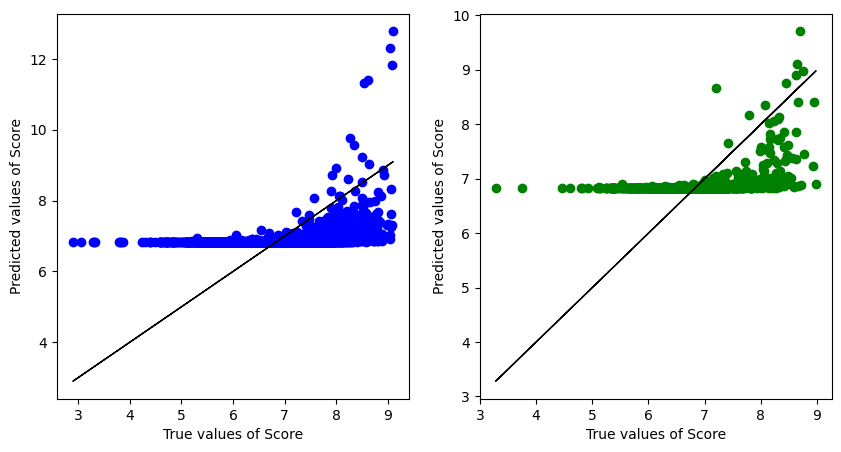

=============== Members ===============
Line Equation
        Score = [[1.12668242e-06]]*Members + [6.70108394]
        
train dataset
        R^2: 0.20158823203440257
        MSE: 0.5133220454129636
test dataset
        R^2: 0.22761372620874543
        MSE: 0.4912769298496683


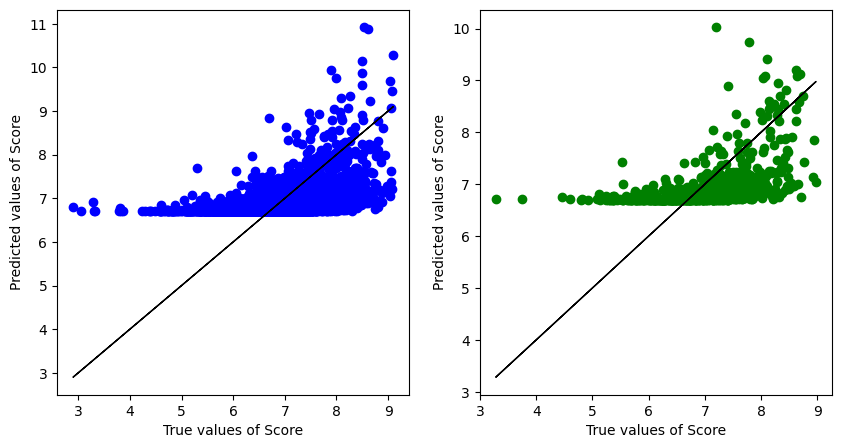

=============== Premier_Month ===============
Line Equation
        Score = [[0.00030781]]*Premier_Month + [6.47797487]
        
train dataset
        R^2: 0.003282476744635776
        MSE: 0.6408185578727997
test dataset
        R^2: -0.002174984450509454
        MSE: 0.6374342297880436


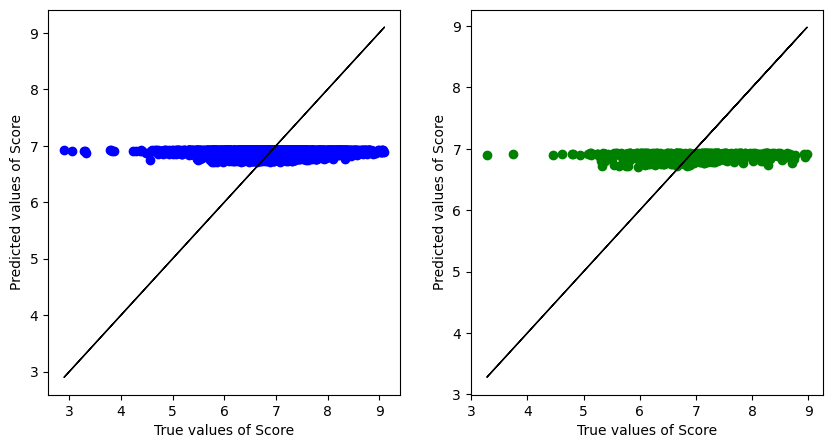

Rank regression
0 dataset
        R^2: 0.9553890300259712
        MSE: 0.028681684406123998
1 dataset
        R^2: 0.9557528431052484
        MSE: 0.028143440829329094
Episodes regression
0 dataset
        R^2: 1.112520188750743e-06
        MSE: 0.6429282419518935
1 dataset
        R^2: -0.004978776731144885
        MSE: 0.6392175841928359
Scored By regression
0 dataset
        R^2: 0.16482027938013433
        MSE: 0.5369612268722093
1 dataset
        R^2: 0.19236791409828313
        MSE: 0.5136950578657105
Popularity regression
0 dataset
        R^2: 0.29236639927876407
        MSE: 0.45495813300790033
1 dataset
        R^2: 0.2863511764159886
        MSE: 0.453916925944665
Favorites regression
0 dataset
        R^2: 0.10790510219916705
        MSE: 0.5735536423873501
1 dataset
        R^2: 0.16141600449363847
        MSE: 0.5333820456327456
Members regression
0 dataset
        R^2: 0.20158823203440257
        MSE: 0.5133220454129636
1 dataset
        R^2: 0.22761372620874543
        

In [173]:
regs = dict([(y , {}) for y in int_cols])
for y in int_cols:
    regs[y]['r2'], regs[y]['mse'] = linear_regression('Score',y,train_set=train_set, test_set=test_set)

for name, res in regs.items():
    print(f"{name} regression")
    for i in range(len(res['r2'])):
        print(f"""{i} dataset
        R^2: {res['r2'][i]}
        MSE: {res['mse'][i]}""")


### Categorical Data
For categorical columns, we can ignore Type (as all seasonals are TV type), and status (whether show is currently airing does not matter much)

For seasons:

    0: Winter
    1: Spring
    2: Summer
    3: Autumn

In [155]:
category_cols.remove('Type')
category_cols.remove('Status')

In [156]:
def plot_categories(x,y):
    """plot the boxplot of x against y, as well as the countplot of y.
    @param x: The variable to be investigated
    @param y: The categorical data"""
    print(f'=============== {y} ===============')
    df2 = df[[y, x]].astype({y:'category'}) # need to set variable as category
    cats = df2[y].cat.categories
    plt.figure(figsize=(8,6))
    sb.countplot(data=df2[y])
    plt.show()
    print(f'categories: {len(cats)}')

    plt.figure(figsize=(8,6))
    sb.boxplot(data=df2, x=x,y=y,orient='h')
    plt.show()

=============== Rating ===============


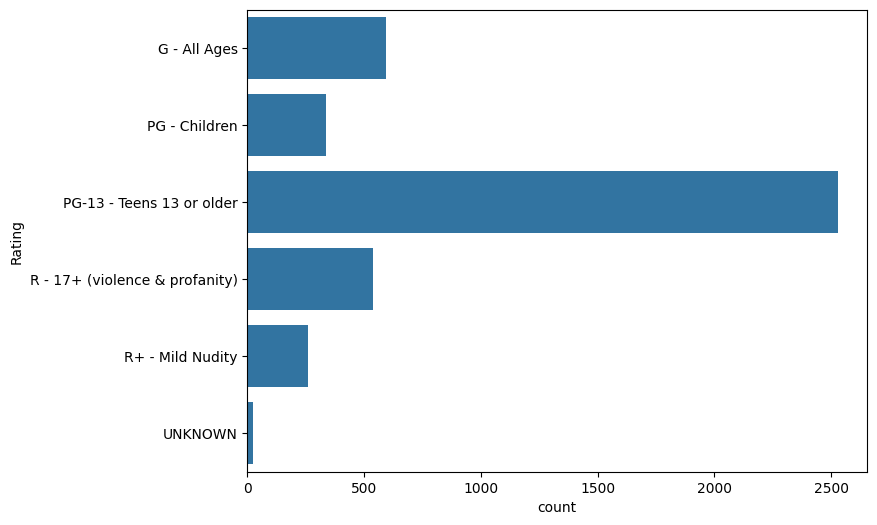

categories: 6


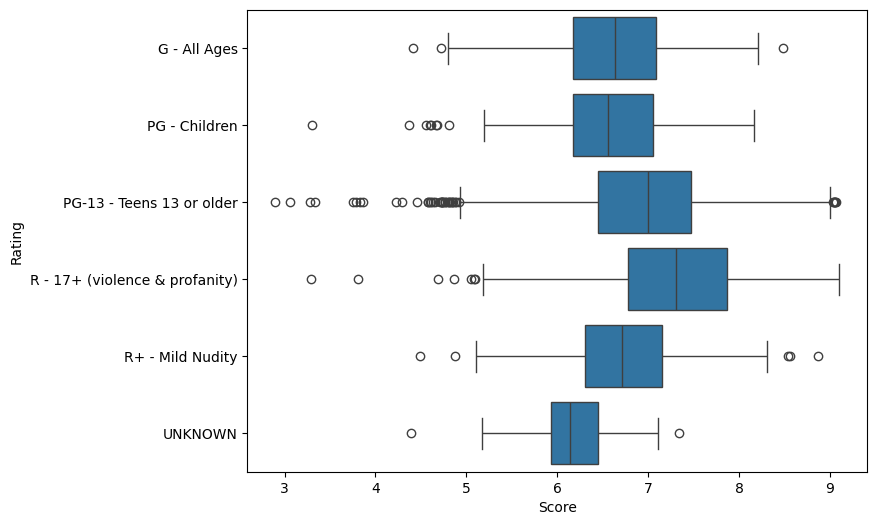

=============== Source ===============


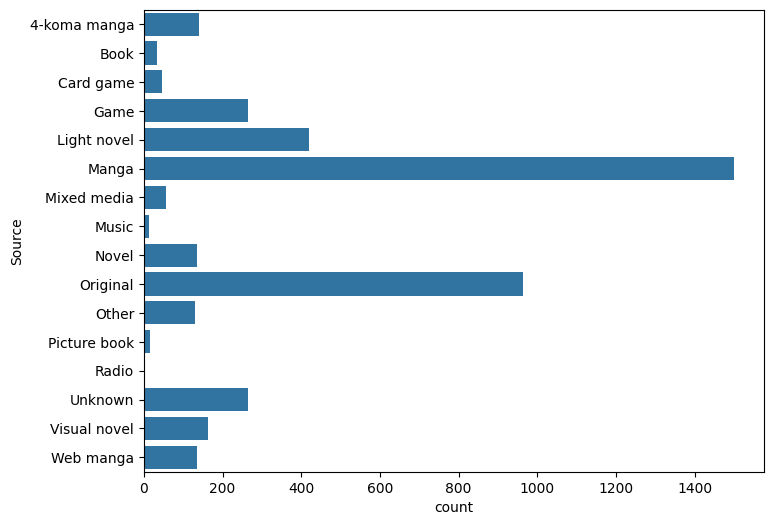

categories: 16


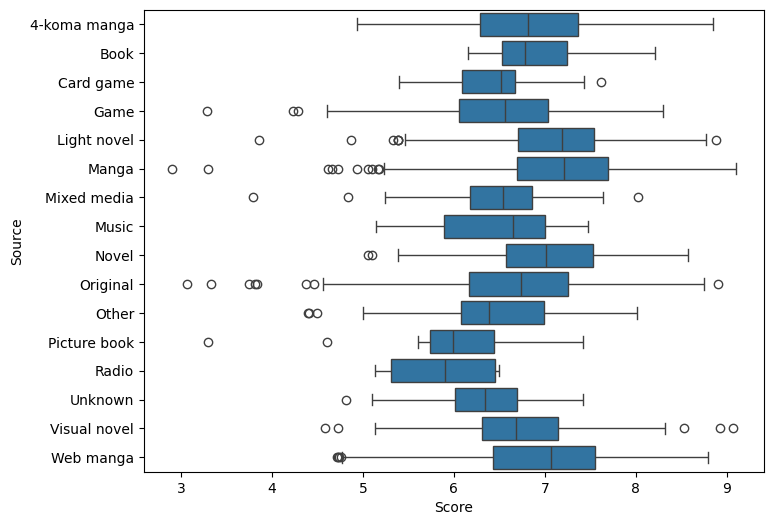

=============== season ===============


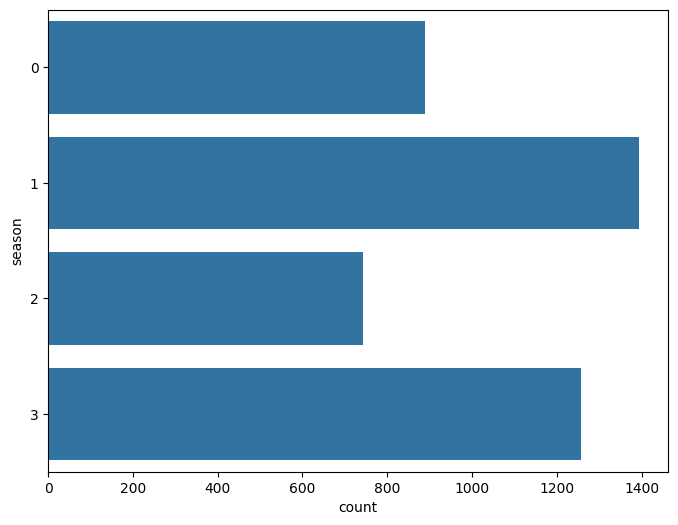

categories: 4


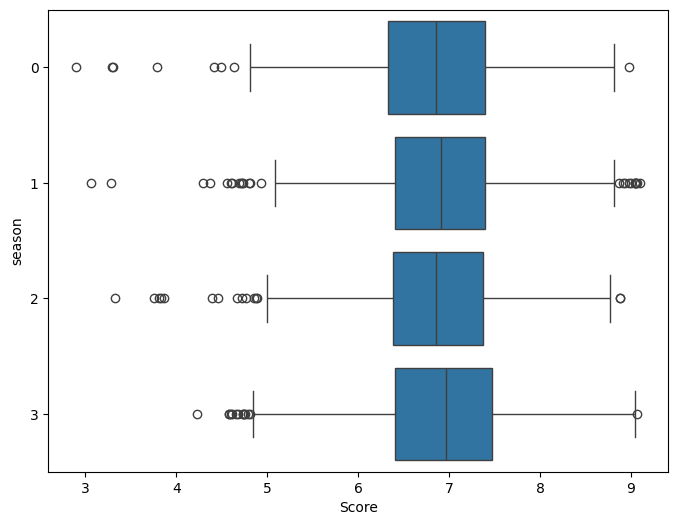

=============== Studio ===============


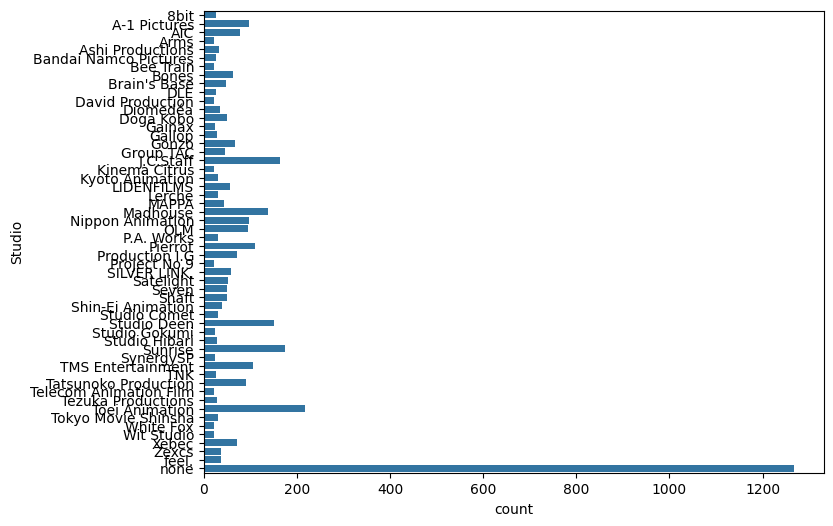

categories: 54


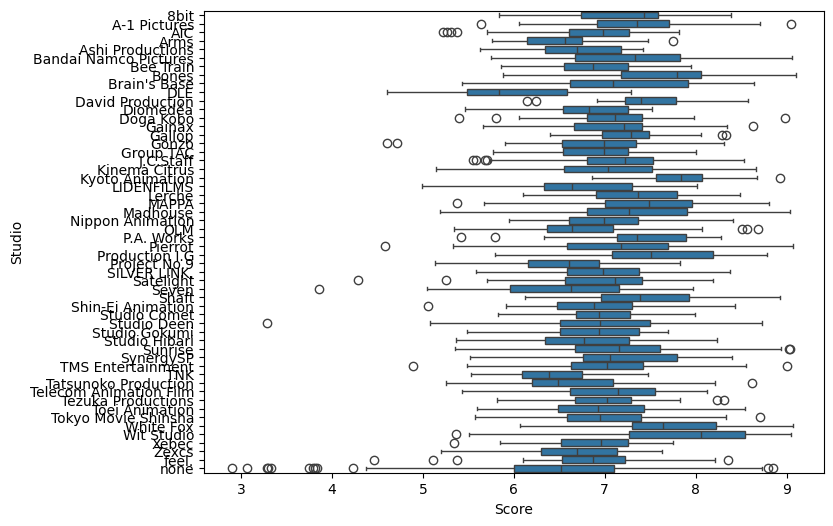

In [157]:
for y in category_cols:
    plot_categories('Score',y)

## Genre Analysis
As Genre shares a many-to-many relationship with Titles, it is not possible to express and analyse in a single column.

=================Action=================


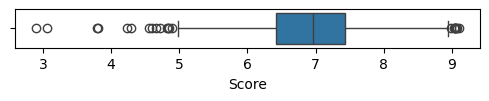

=================Adventure=================


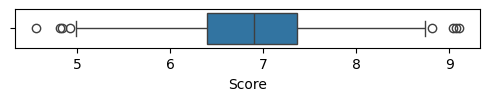

=================Avant Garde=================


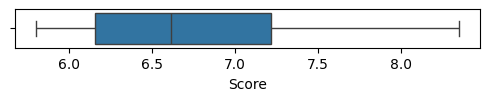

=================Award Winning=================


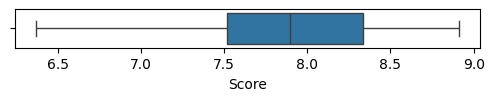

=================Boys Love=================


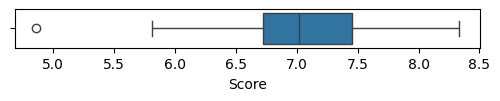

=================Comedy=================


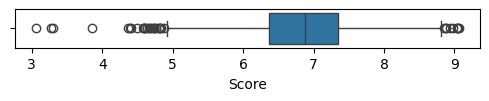

=================Drama=================


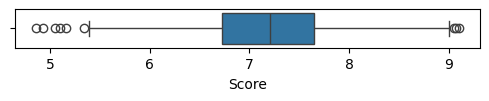

=================Fantasy=================


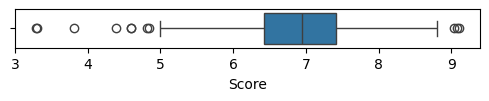

=================Girls Love=================


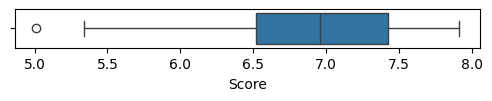

=================Gourmet=================


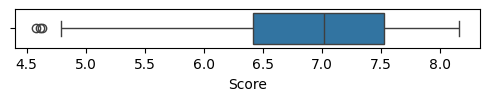

=================Horror=================


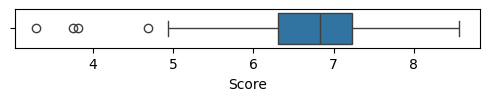

=================Mystery=================


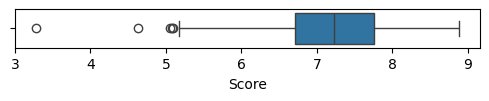

=================Romance=================


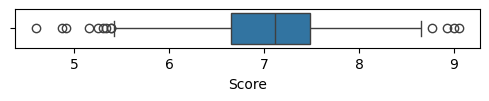

=================Sci-Fi=================


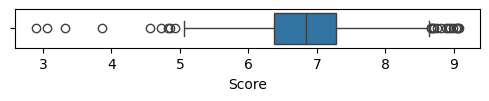

=================Slice of Life=================


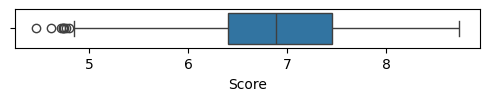

=================Sports=================


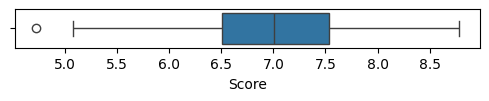

=================Supernatural=================


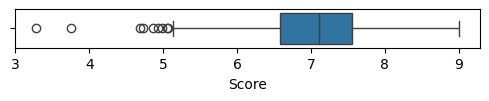

=================Suspense=================


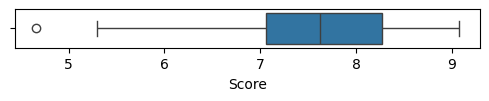

=================Ecchi=================


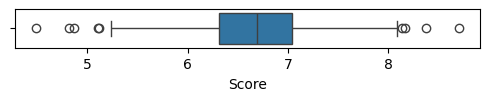

,Genre,Count,25,50,75
0,Action,1458,6.4200,6.960,7.4300
1,Adventure,995,6.4000,6.900,7.3600
2,Avant Garde,18,6.1550,6.615,7.2200
3,Award Winning,54,7.5150,7.895,8.3325
4,Boys Love,30,6.7225,7.020,7.4550
5,Comedy,1826,6.3700,6.880,7.3500
6,Drama,830,6.7300,7.205,7.6475
7,Fantasy,1091,6.4200,6.940,7.4150
8,Girls Love,43,6.5200,6.960,7.4250
9,Gourmet,57,6.4200,7.020,7.5300


In [166]:
# this will become the dataframe storing the genre stats
genre_stats = []

for genre in genres:
    print(f'================={genre}=================')
    df2 = df[df[genre]==True]
    stats = [genre]

    # get count
    count = len(df2.index)
    stats.append(count)
    
    # get quantiles
    quantiles = [0.25,0.5,0.75]
    for quantile in quantiles:
        stats.append(df2['Score'].quantile(quantile))

    plt.figure(figsize=(6,0.5))
    sb.boxplot(data=df2['Score'],orient='h')
    plt.show()

    genre_stats.append(stats)
    
genre_stats = pd.DataFrame(genre_stats,columns=['Genre','Count','25','50','75'])
genre_stats

# Performing Predictions
We use popularity, and the encoded genres and studios. Using rank is cheating as it is based on score.

In [ ]:
y = genres.copy()
y = y + studios
y.append('Popularity')

### Ordinary Least Squares
The most simple & basic form of regression. It has the best results of the tested models.

=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'Wit Studio', 'Popul

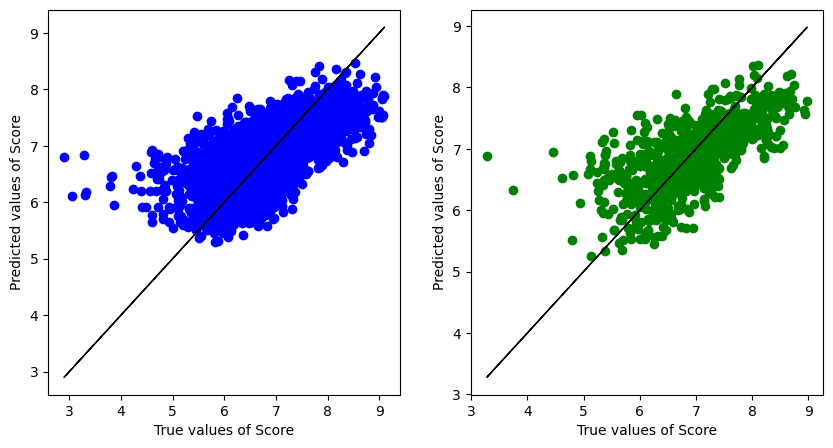

([0.43740052867225643, 0.43407890433173435],
 [0.36171149143514764, 0.35995458211910797])

In [176]:
linear_regression(x='Score',y=y,train_set=train_set, test_set=test_set)

### K Nearest Neighbours
This doesn't seem to work very well, we need a high value of k (around 30) to get a decent R^2, suggesting too much generalisation

In [169]:
def knn(x:str, y:str, train_set:object, test_set:object, k:int):
    """does K nearest Neighbour regression of variable y in the dataset against x. Can accept a list as y.
    @param x: The variable we want to predict
    @param y: The list of variables to perform regression on.
    @param train_set: The set used for training the model.
    @param test_set: The set used to test the model's accuracy.
    @param k: The number of neighbours
    @returns R^2: The R^2 values of the model, train set then test set.
    @returns MSE: The MSE values of the model, train set then test set."""

    print(f'=============== {y} ===============')
    neighreg = KNeighborsRegressor(n_neighbors=k)
    # check if list
    if type(y) is list:
        neighreg.fit(train_set[y],train_set[[x]])
    else:
        neighreg.fit(train_set[[y]],train_set[[x]])


    datasets = {'train':train_set, 'test':test_set}
    results = {}

    r2_arr = []
    mse_arr = []
    
    for name,dataset in datasets.items():
        if type(y) is list:
            datay = dataset[y]
        else:
            datay = dataset[[y]]
        pred = neighreg.predict(datay)
        
        r2 = neighreg.score(datay, dataset[[x]])
        mse = mean_squared_error(dataset[[x]], pred)

        r2_arr.append(r2)
        mse_arr.append(mse)

        print(f"""{name} dataset
        R^2: {r2}
        MSE: {mse}""")
        results[name] = pred

    prediction_plot(x,train_set,test_set,results)

    return r2_arr, mse_arr

=== k = 5 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'Wit S

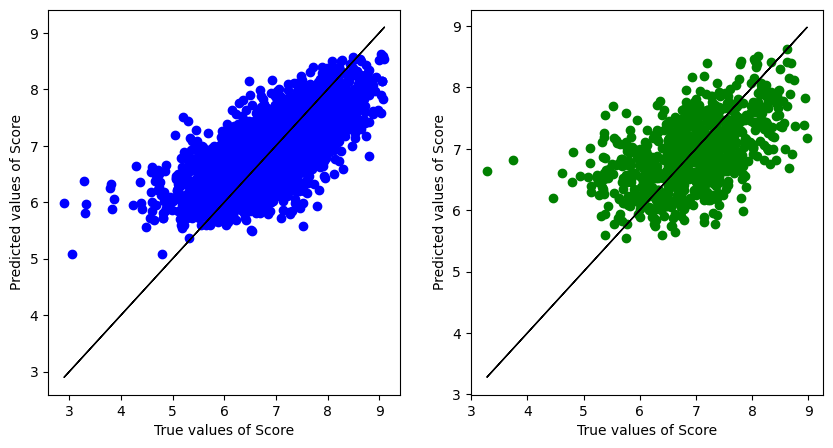

=== k = 10 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'Wit 

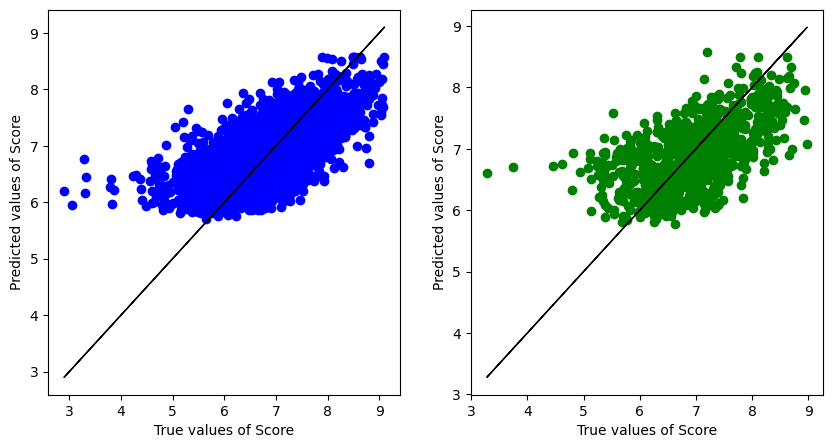

=== k = 15 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'Wit 

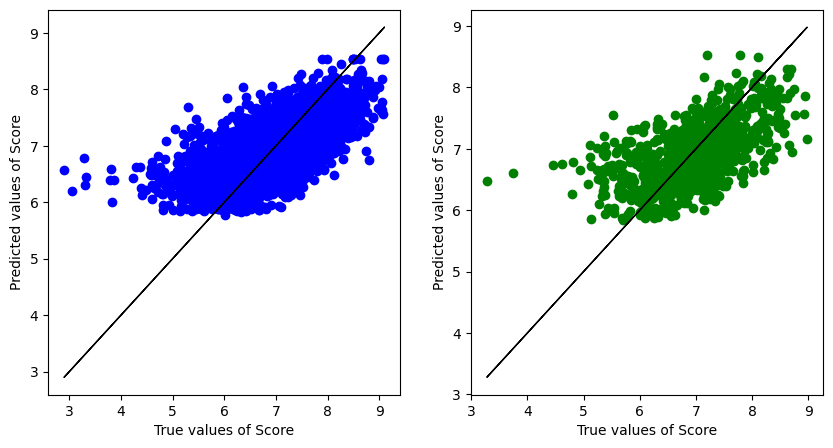

=== k = 20 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'Wit 

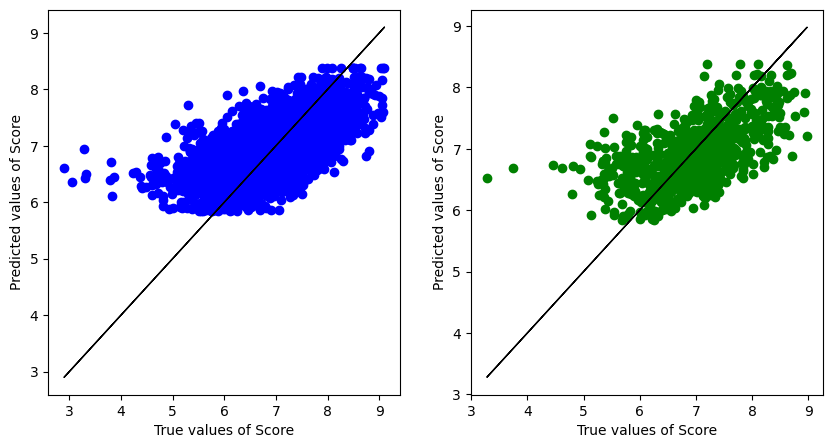

=== k = 25 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'Wit 

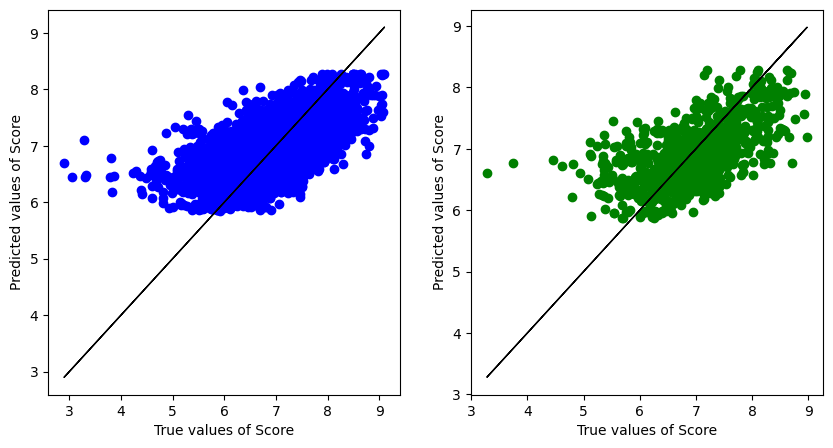

=== k = 30 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'Wit 

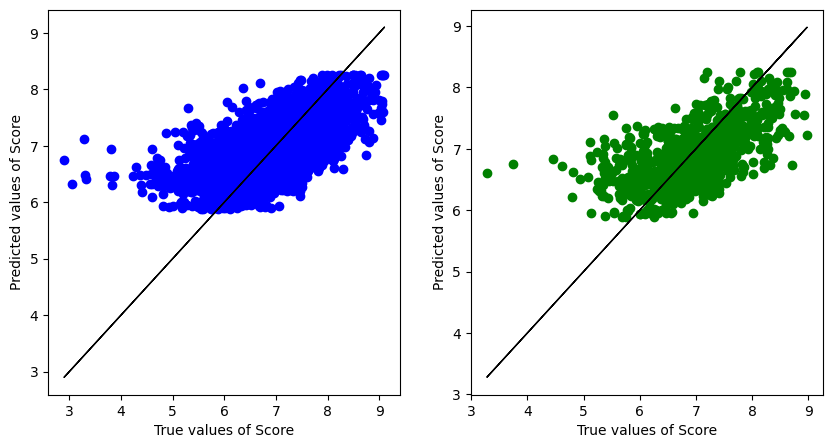

In [170]:
for i in range(5,35,5):
    print(f'=== k = {i} ===')
    knn(x='Score',y=y,train_set=train_set, test_set=test_set, k=i)

### Decision Tree
This seems to perform worse than Ordinary Least Squares, despite testing multiple depths.

In [163]:
def tree(x:str, y:str, train_set:object, test_set:object, max_depth:int=None):
    """does decision tree regression of variable y in the dataset against x. Can accept a list as y.
    @param x: The variable we want to predict
    @param y: The list of variables to perform regression on.
    @param train_set: The set used for training the model.
    @param test_set: The set used to test the model's accuracy.
    @param max_depth: maximum depth of tree
    @returns R^2: The R^2 values of the model, train set then test set.
    @returns MSE: The MSE values of the model, train set then test set."""

    print(f'=============== {y} ===============')
    treereg = DecisionTreeRegressor(max_depth=max_depth)
    # check if list
    if type(y) is list:
        treereg.fit(train_set[y],train_set[[x]])
    else:
        treereg.fit(train_set[[y]],train_set[[x]])

    datasets = {'train':train_set, 'test':test_set}
    results = {}

    r2_arr = []
    mse_arr = []
    
    for name,dataset in datasets.items():
        if type(y) is list:
            datay = dataset[y]
        else:
            datay = dataset[[y]]
        pred = treereg.predict(datay)
        
        r2 = treereg.score(datay, dataset[[x]])
        mse = mean_squared_error(dataset[[x]], pred)

        r2_arr.append(r2)
        mse_arr.append(mse)

        print(f"""{name} dataset
        R^2: {r2}
        MSE: {mse}""")
        results[name] = pred

    prediction_plot(x,train_set,test_set,results)

    return r2_arr, mse_arr

=== DEPTH = 3 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'W

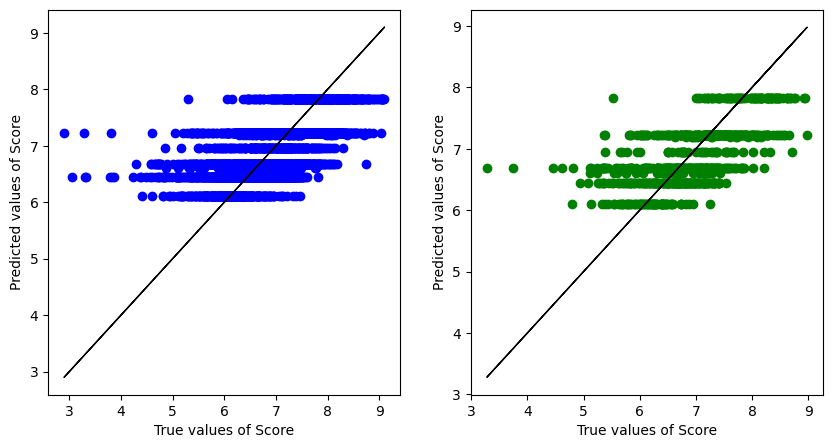

=== DEPTH = 4 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'W

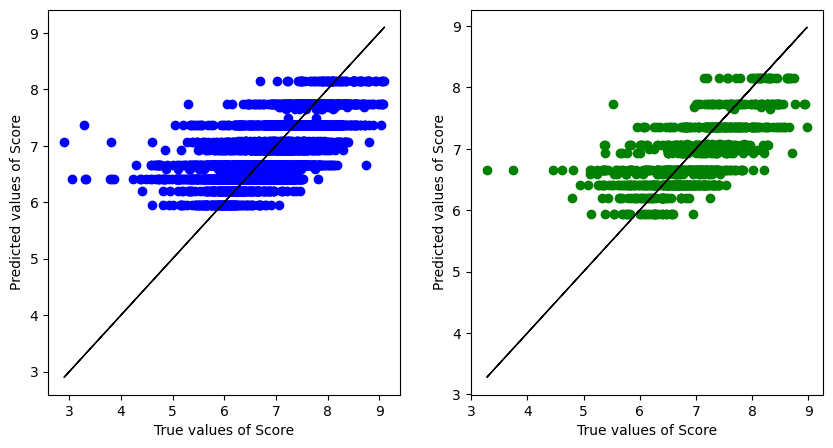

=== DEPTH = 5 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'W

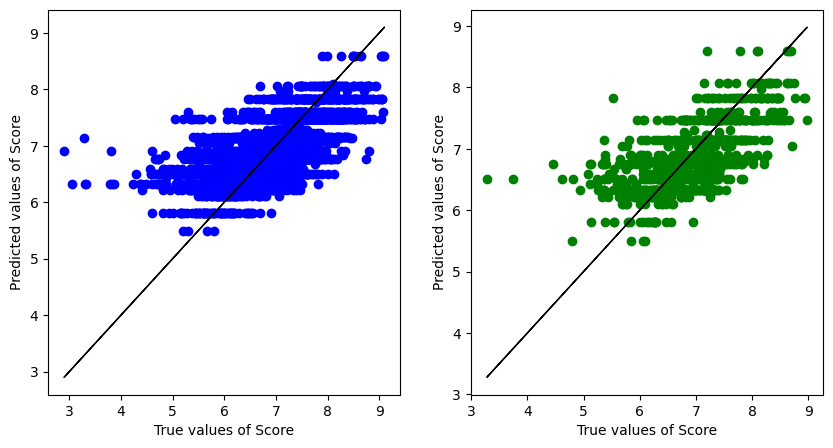

=== DEPTH = 6 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'W

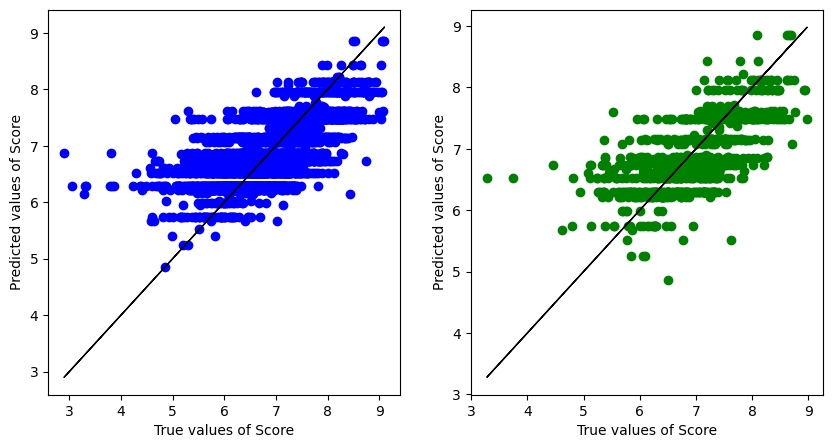

=== DEPTH = 7 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'W

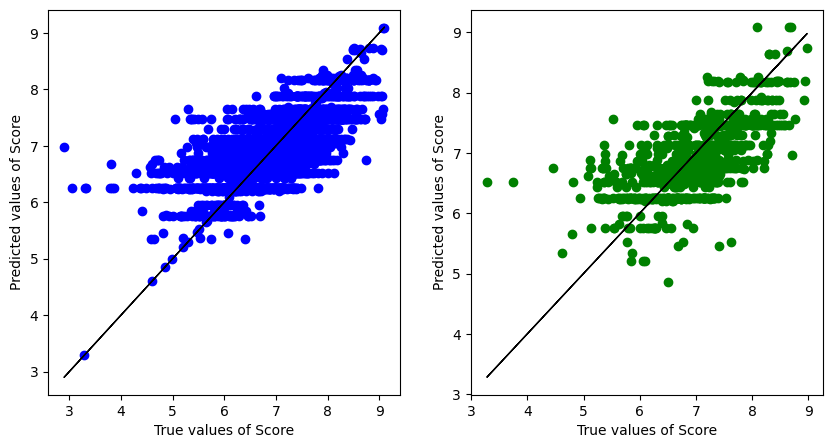

=== DEPTH = 8 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'W

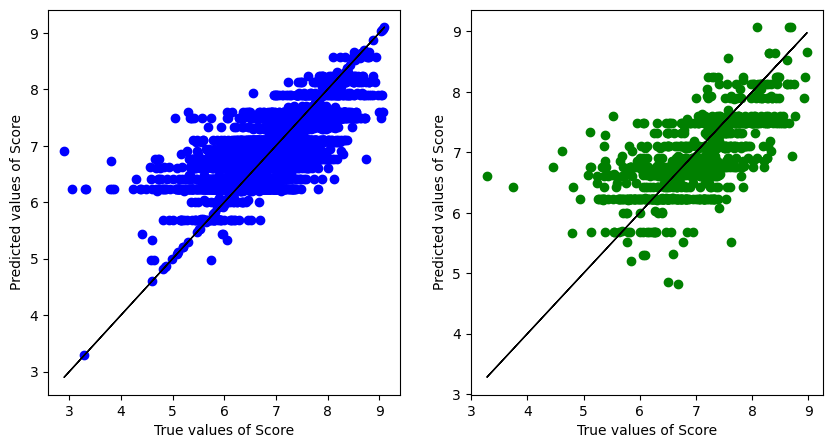

=== DEPTH = 9 ===
=============== ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Boys Love', 'Comedy', 'Drama', 'Fantasy', 'Girls Love', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense', 'Ecchi', 'Toei Animation', 'Sunrise', 'J.C.Staff', 'Madhouse', 'Studio Deen', 'TMS Entertainment', 'Nippon Animation', 'Pierrot', 'A-1 Pictures', 'OLM', 'Tatsunoko Production', 'Production I.G', 'Gonzo', 'Xebec', 'Bones', 'SILVER LINK.', 'Satelight', 'Doga Kobo', 'Shaft', "Brain's Base", 'LIDENFILMS', 'Group TAC', 'MAPPA', 'Shin-Ei Animation', 'feel.', 'Diomedéa', 'AIC', 'Studio Comet', 'Zexcs', 'Kyoto Animation', 'Lerche', 'Tokyo Movie Shinsha', 'P.A. Works', 'Gallop', 'Ashi Productions', 'Studio Hibari', '8bit', 'DLE', 'Tezuka Productions', 'Seven', 'Studio Gokumi', 'Bandai Namco Pictures', 'Gainax', 'Bee Train', 'Kinema Citrus', 'SynergySP', 'Arms', 'Project No.9', 'David Production', 'TNK', 'Telecom Animation Film', 'White Fox', 'W

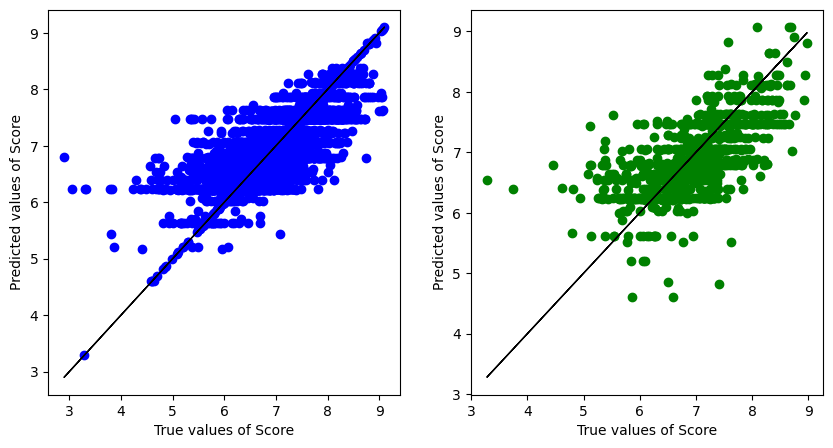

In [164]:
for i in range (3,10):
    print(f'=== DEPTH = {i} ===')
    tree(x='Score',y=y,train_set=train_set, test_set=test_set, max_depth=i)